# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL (CS-401). 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### Import libraries

In [1]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from langdetect import detect
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
import time

from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog, smog_index, automated_readability_index, coleman_liau_index, linsear_write_formula, dale_chall_readability_score, text_standard
from utils import *
pd.set_option('display.max_columns', None)

dataset_path = './data/BeerAdvocate/'

## 1. Datasets 📂

### 1.1 Import dataset

In [2]:
# Firt time imports : 
# Convert txt to csv (function in the utils.py file)

#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

In [3]:
# Files already converted, so we can load them directly

reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### 1.2 Initial datasets analysis 🔎

#### 1.2.1 Beers dataset 🍺

In [4]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
17380,288226,Manitou Stout Impérial ZAB Café,40582,MABRASSERIE,Russian Imperial Stout,1,0,3.96,NaN,NaN,11.9,3.960,NaN,0,NaN
29257,112145,MSB,33977,Covered Bridge Brewing,American Brown Ale,5,0,3.17,NaN,NaN,9.1,3.172,NaN,0,NaN
270757,46451,Smoke In Your Rye,10152,Moonshine,Smoked Beer,1,1,2.96,NaN,NaN,6.0,2.960,NaN,0,NaN


Shape of beers :  (280823, 15)


In [5]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

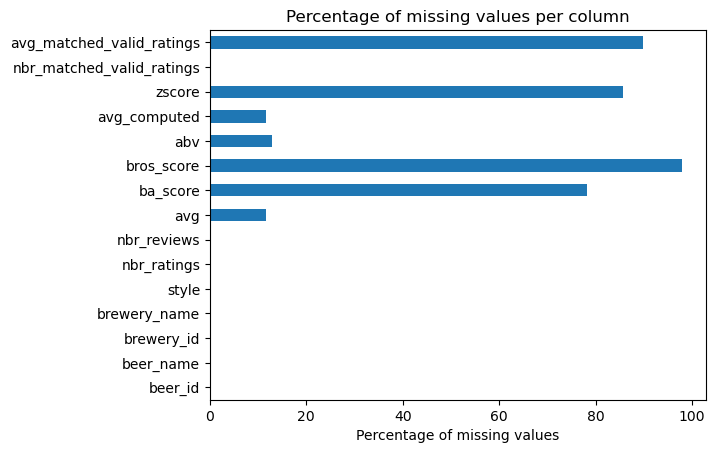

How many values missing per column in %:


beer_id                       0.000000
beer_name                     0.000000
brewery_id                    0.000000
brewery_name                  0.000000
style                         0.000000
nbr_ratings                   0.000000
nbr_reviews                   0.000000
avg                          11.690282
ba_score                     78.206913
bros_score                   97.969540
abv                          12.828009
avg_computed                 11.694555
zscore                       85.654665
nbr_matched_valid_ratings     0.000000
avg_matched_valid_ratings    89.932449
dtype: float64

In [6]:
# show the percentage of missing values per columm
plt.figure()
(beers.isna().sum() / len(beers) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

#print how many values are missing in each column in %
print('How many values missing per column in %:')
display(beers.isna().sum()/ len(beers) * 100)

<blockquote>

**More comments about the dataset**

We see that more than 80% of the beers do not have a z-score value. We can drop this column alongside avg_computed and compute them manually later if needed from the reviews dataset. 

80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

The other columns with NaN such as avg_matched_valid_ratings, avg_computed or bros_score are not usefull in our analysis since we only look at the BeerAdvocate reviews.

However, the abv, which represents the alcohol percentage in a beer, is missing for approximately 12%.

</blockquote>

In [7]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [8]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
175718,79155,26536,Scottish Ale,2,2,3.52,4.25
177489,215144,22655,Baltic Porter,8,3,3.96,9.00
35541,148016,31856,Quadrupel (Quad),1,0,3.50,12.00


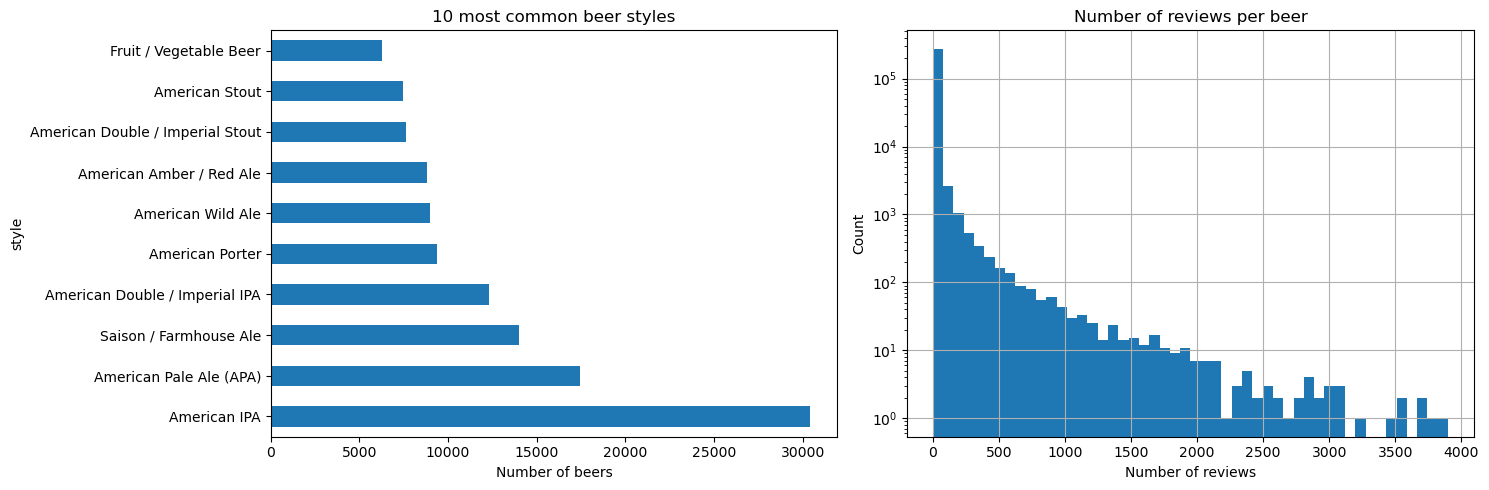

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


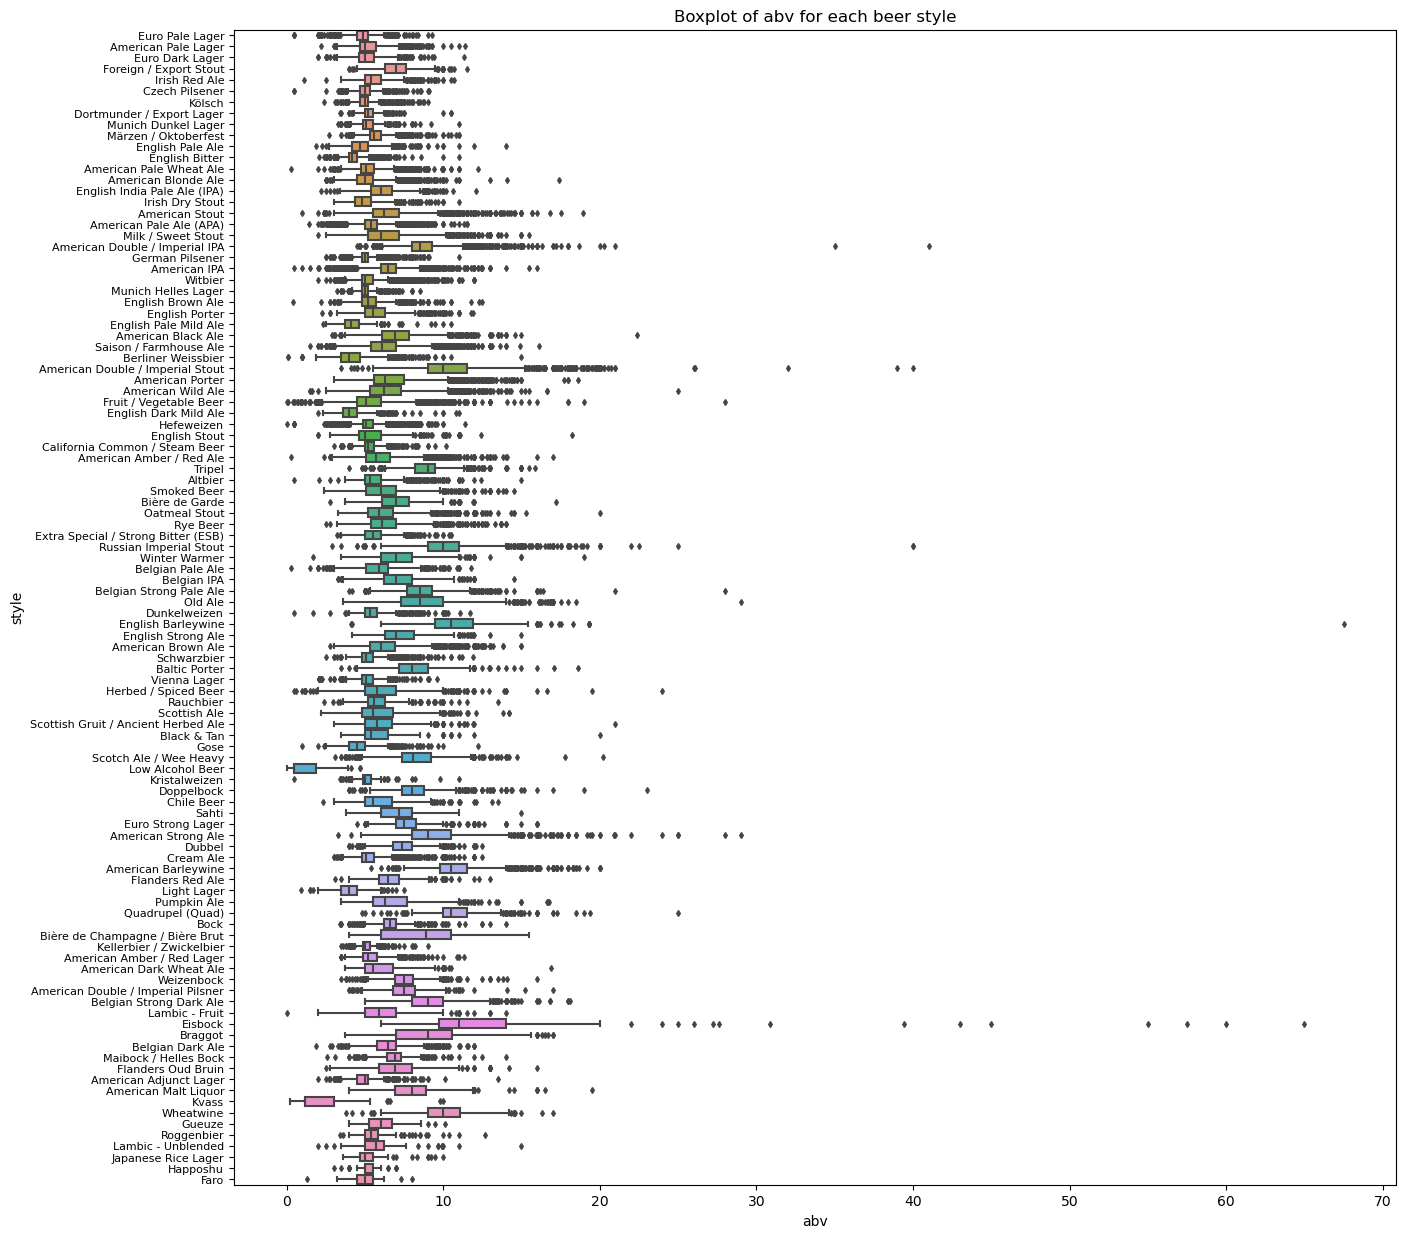

In [10]:
# show boxplot of abv for each beer style
plt.figure(figsize=(15, 15))
sns.boxplot(y='style', x='abv', data=beers_filtered, fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for each beer style')
plt.show()

In [11]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

style
Japanese Rice Lager               5.0
California Common / Steam Beer    5.2
German Pilsener                   5.0
Name: abv, dtype: float64

In [12]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### 1.2.2 Breweries dataset 🏭

In [13]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
13730,48529,"United States, Texas",Fredonia Brewery,0
5700,18108,Australia,Brewboys,13
8634,30228,"United States, California",Ironfire Brewing Company,34


Shape of breweries :  (16758, 4)


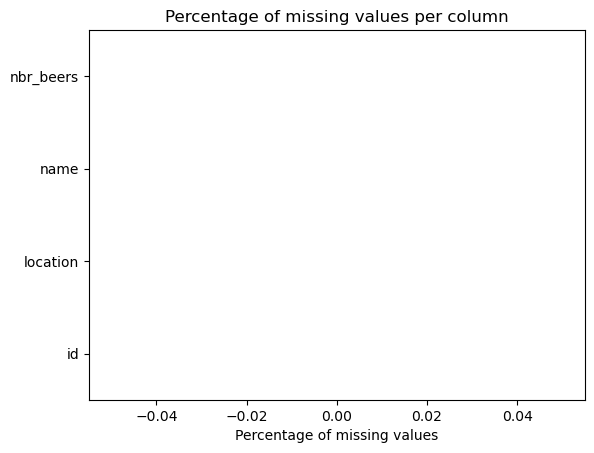

In [14]:
# show the percentage of missing values per columm
plt.figure()
(breweries.isna().sum() / len(breweries) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [15]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)
breweries_filtered = breweries.copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [16]:
breweries_filtered.sample(3)

,brewery_id,brewery_location,name,brewery_nbr_beers
236,43683,England,Keelham Farm Shop,1
15018,3672,France,Brasserie Terken,0
14493,4561,Belgium,Brasserie Augrenoise,4


In [17]:
# Some breweries have weird location values, should find a way to clean them
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# should manully add the us state of the 35 breweries because it corresponds to to 15'319 reviews.

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [18]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()
strange_id

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'

In [19]:
# create a function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [20]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        # print('Brewery name:', breweries_filtered[breweries_filtered['brewery_id'] == key]['name'].values[0])
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [21]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [22]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [23]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


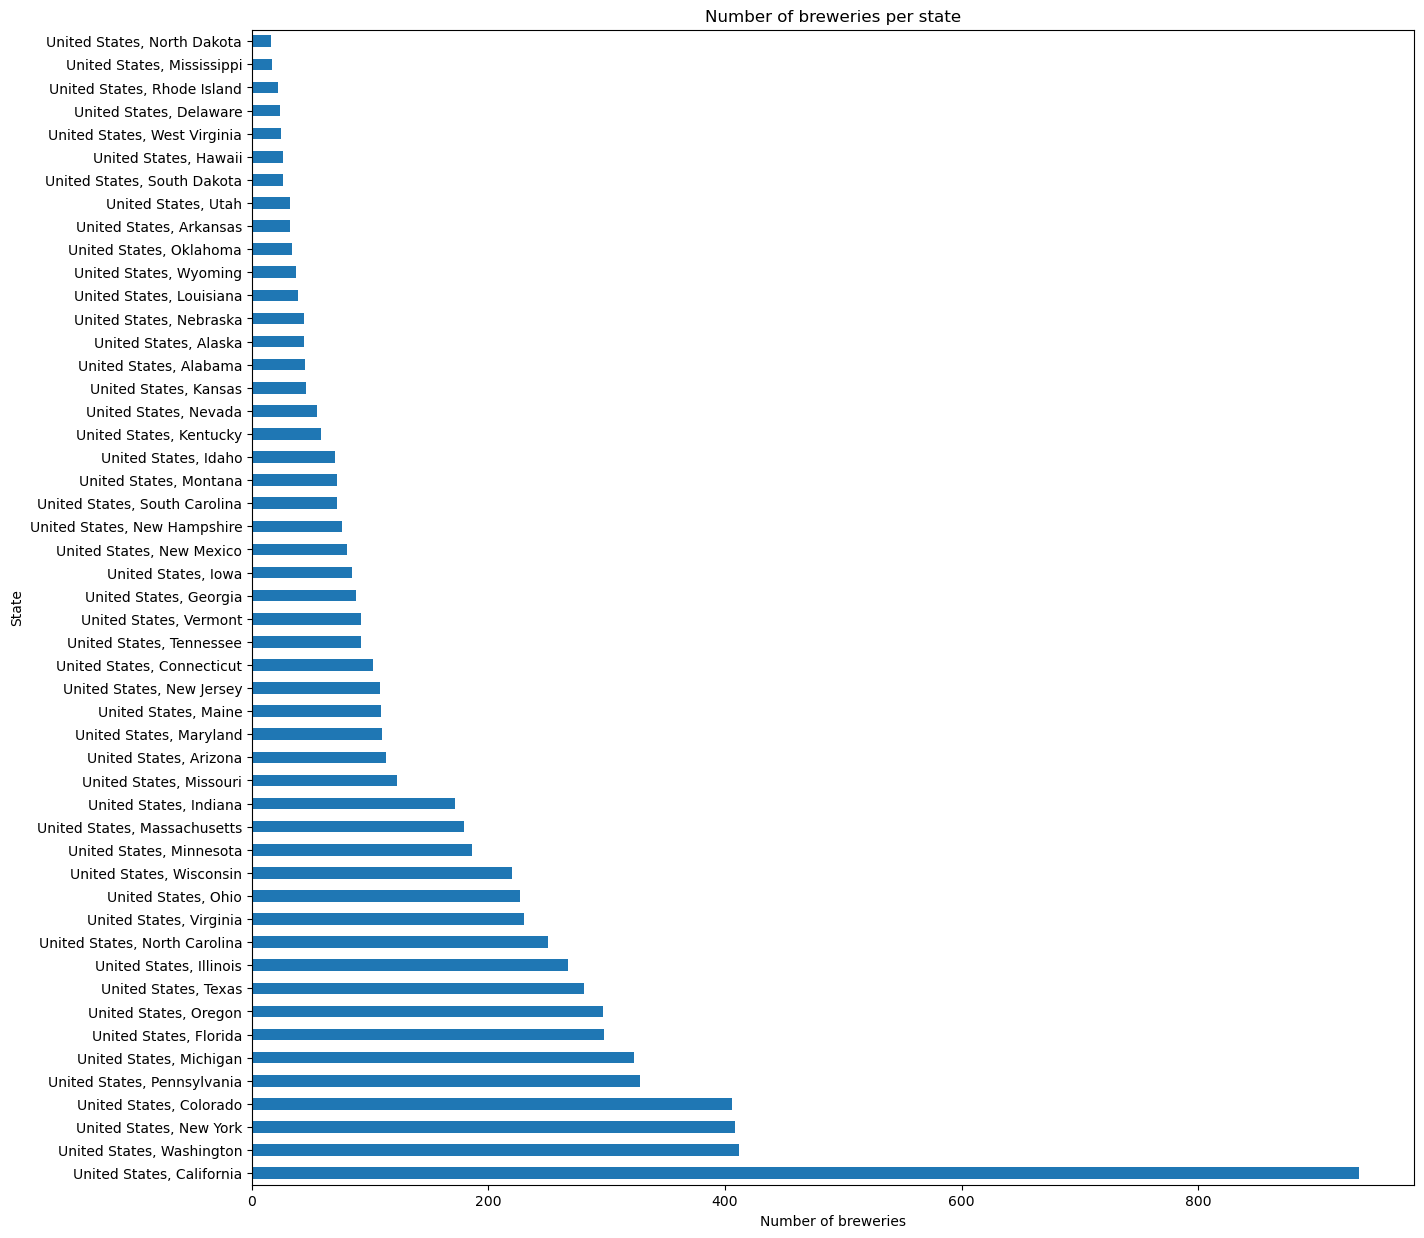

In [24]:
# plot the number of breweries per state as barh
plt.figure(figsize=(15, 15))
breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].value_counts().plot(kind='barh')
plt.title('Number of breweries per state')
plt.xlabel('Number of breweries')
plt.ylabel('State')
plt.show()

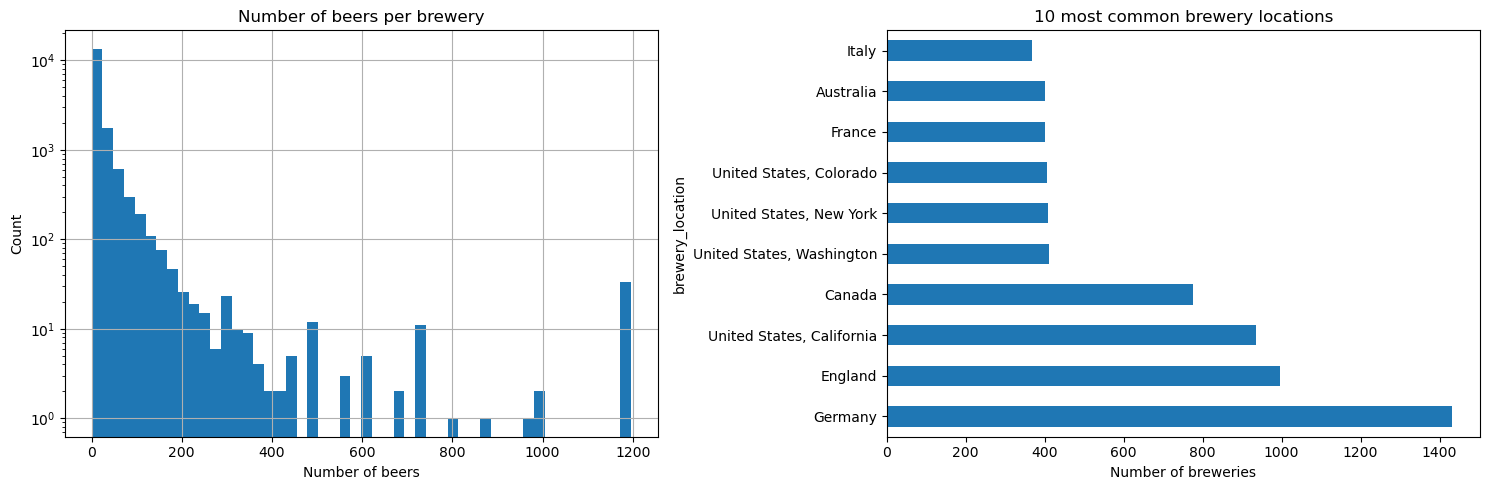

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### 1.2.3 Users dataset 👤

In [26]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
1493,13,0,chefmemo72.858042,Chefmemo72,1.409825e+09,NaN
141687,1,0,rastro.733280,rastro,1.368958e+09,"United States, Rhode Island"
46486,1,1,sbb11.202706,sbb11,1.205320e+09,"United States, Massachusetts"


Shape of users :  (153704, 6)


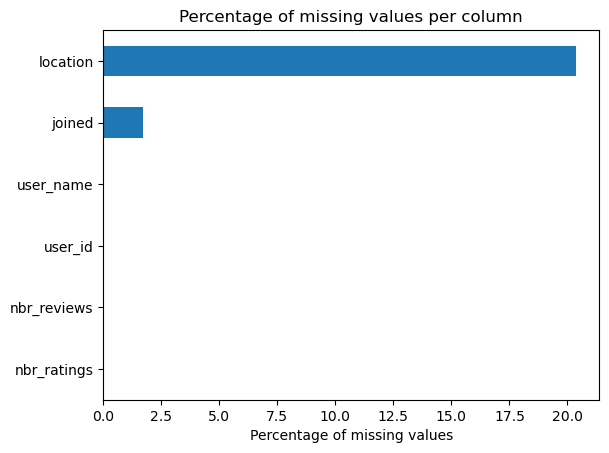

In [27]:
plt.figure()
(users.isna().sum() / len(users) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [28]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

users_filtered.sample(3)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
126682,1,0,bill_huggins.688884,1.344679e+09,"United States, Virginia"
30852,10,0,mikelover.803523,1.402049e+09,"United States, California"
88811,1,0,ostentatiousblue.672479,1.334311e+09,"United States, California"


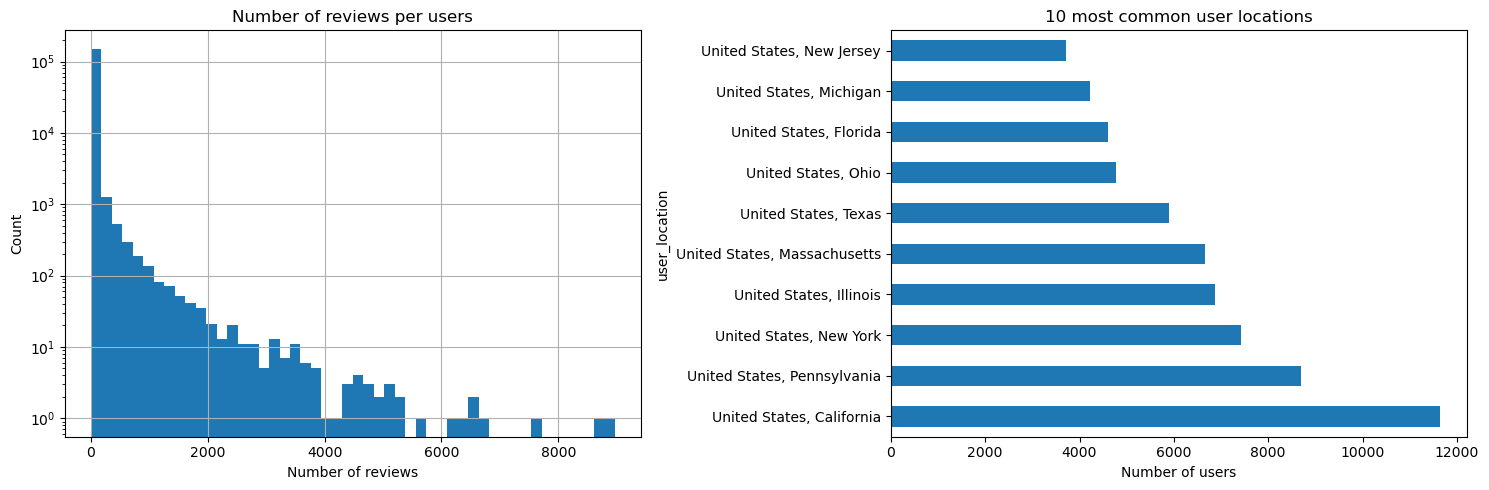

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### 1.2.4 Reviews dataset 📝

In [30]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
1621957,Rolling Rock Extra Pale,567,Latrobe Brewing Co.,174,American Adjunct Lager,4.6,1140433200,kdmorse,kdmorse.30277,2.5,3.0,3.0,3.0,3.0,2.97,A: Light straw color topped with 1 finger of w...
830299,Trippel,34175,Green Flash Brewing Co.,2743,Tripel,9.7,1338199200,smakawhat,smakawhat.204323,4.0,4.0,4.5,4.0,4.0,4.05,Poured from the bottle slowly into a tulip gla...
874331,Stone Ruination IPA,4083,Stone Brewing,147,American Double / Imperial IPA,8.2,1351940400,Mavigo,mavigo.684241,4.0,4.5,4.0,4.0,4.0,4.12,"Ugh. I've really been liking Stone's beers, bu..."


Shape of reviews :  (2589586, 16)


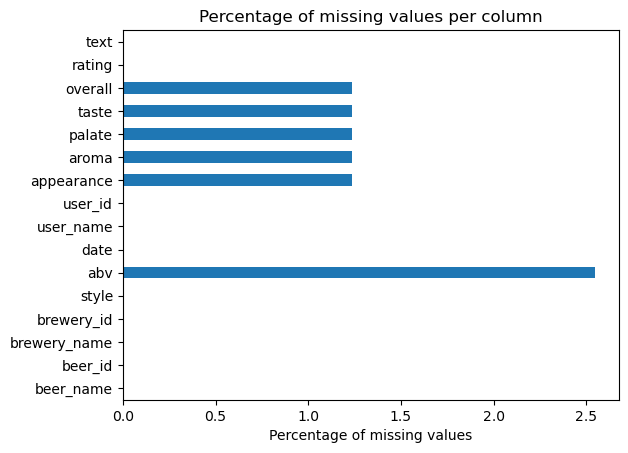

In [31]:
plt.figure()
(reviews.isna().sum() / len(reviews) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [32]:
# making sure that all the NaN are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009
all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [33]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
1643641,56168,423,Rye Beer,1291028400,kenito799.92945,4.0,4.5,4.0,4.5,4.0,4.32,220z bomberChestnut brown brew with rocky foam...
125713,31,22,Witbier,1028628000,bighuge.188,3.5,4.0,3.5,3.5,3.0,3.52,The beer is cloudy and golden orange. It thro...
2038497,1093,287,American IPA,1242986400,pmccallum86.317434,4.0,4.5,4.5,4.5,5.0,4.57,This is one of my utmost favorite IPAs. It has...


Shape of reviews_filtered :  (2557577, 12)


In [34]:
# count the number of NaN in columns ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews_filtered[reviews_filtered[col].isna()]))


Number of NaN values for each column :
overall : 0
taste : 0
palate : 0
aroma : 0
appearance : 0


/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annevaleriepreto/miniforge3/envs/ADA/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

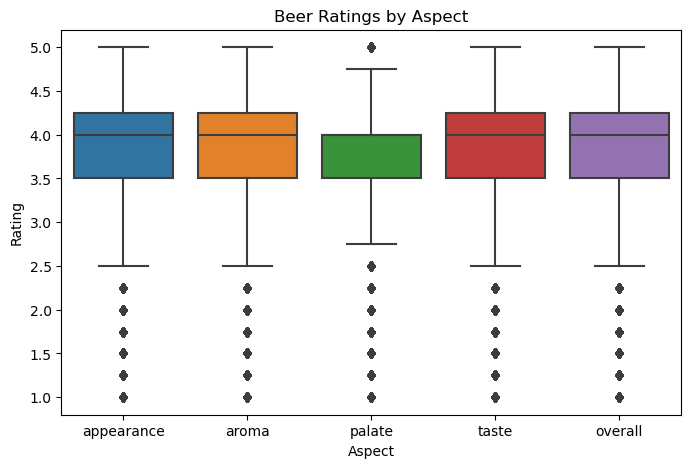

In [35]:
# show boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### 1.3 Merge datasets 🔗

In [36]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,name,brewery_nbr_beers
1971005,57110,14879,Russian Imperial Stout,1360494000,wanderingfool.601,3.0,3.75,4.25,4.25,4.25,4.06,D.O.R.I.S. pours flat black with barely any fo...,1308,443,4.2,10.5,1699,931,1.028714e+09,"United States, Massachusetts","United States, Ohio",Hoppin' Frog Brewery,104


Shape of df_merged :  (2557577, 23)


### 1.4 Filter datasets ✂️

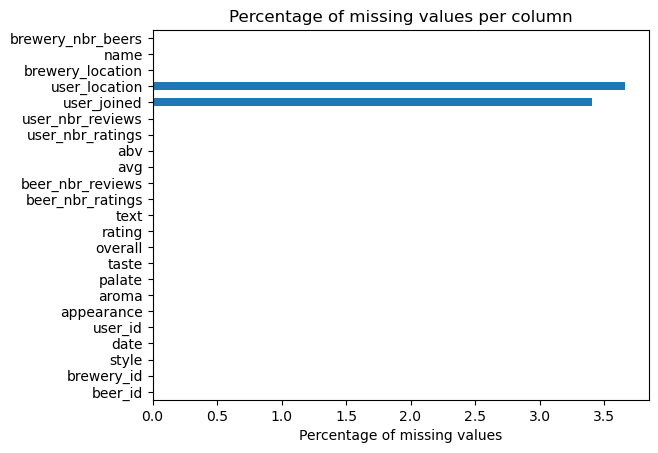

In [37]:
# show the percentage of missing values per columm
plt.figure()
(df_merged.isna().sum() / len(df_merged) * 100).plot(kind='barh', title='Percentage of missing values per column')
plt.xlabel('Percentage of missing values')
plt.show()

In [38]:
# how many reviews have strange brewery location ?
print('Number of reviews with a weird location value:', len(df_merged[df_merged['brewery_location'].str.contains('<', na=False)]))

Number of reviews with a weird location value: 0


In [39]:
# how many reviews have no abv value ?
print('Number of reviews with no abv value:', len(df_merged[df_merged['abv'].isna()]))

Number of reviews with no abv value: 0


In [40]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

In [41]:
# What is the percentage of reviews with at least one NaN value ?
print('Percentage of reviews with at least one NaN value :', len(df_merged[df_merged.isna().any(axis=1)]) / len(df_merged) * 100)
print('This corresponds to', len(df_merged[df_merged.isna().any(axis=1)]), 'reviews')

Percentage of reviews with at least one NaN value : 3.662450827482418
This corresponds to 93670 reviews


Text(0.5, 0, 'Percentage of missing values')

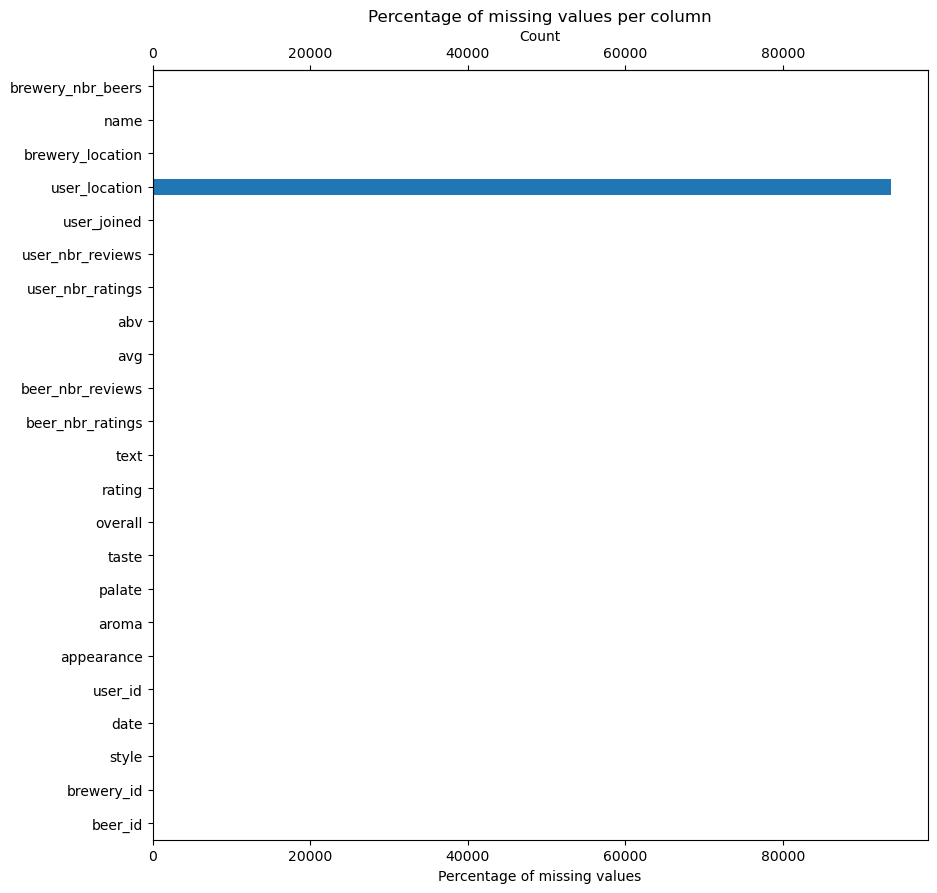

In [42]:
# show the percentage of missing values per columm
plt.figure(figsize=(10, 10))
missing_values = df_merged.isna().sum()
missing_percentages = missing_values / len(df_merged) * 100
ax = missing_values.plot(kind='barh', title='Percentage of missing values per column')
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel('Count')
ax.set_xlabel('Percentage of missing values')

<div class="alert alert-block alert-danger">
<b>Danger:</b> Missing two reviews (NaN)
should change this plot (and the others) so that it becomes visible
</div>

In [43]:
# remove the rows that have a missing text value
df_merged = df_merged[~df_merged['text'].isna()].copy(deep=True)

In [44]:
# Save to csv
df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

## 2. Data enrichment 🍺

In [2]:
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [3]:
df.isna().sum()

beer_id                  0
brewery_id               0
style                    0
date                     0
user_id                  0
appearance               0
aroma                    0
palate                   0
taste                    0
overall                  0
rating                   0
text                     0
beer_nbr_ratings         0
beer_nbr_reviews         0
avg                      0
abv                      0
user_nbr_ratings         0
user_nbr_reviews         0
user_joined              0
user_location        93668
brewery_location         0
name                     0
brewery_nbr_beers        0
dtype: int64

In [4]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,name,brewery_nbr_beers
1269016,108182,25436,English Barleywine,1401098400,uclabrewn84.439438,3.75,4.25,4.0,4.0,4.0,4.05,Thanks to jmgrub for sharing this one at the R...,56,9,4.06,10.2,9944,8768,1.268910e+09,"United States, California","United States, Colorado",Copper Kettle Brewing Company,83
2397355,20134,3517,Euro Pale Lager,1301824800,dedrinker.78484,3.50,3.50,3.5,3.5,3.5,3.50,Light straw color with a white head.Aromas of ...,140,78,3.13,5.0,555,555,1.147514e+09,"United States, Kansas",Belgium,Brouwerij Martens NV,63
2437180,695,222,Belgian Strong Pale Ale,1283335200,r0nyn.355593,4.00,4.00,4.5,4.0,4.5,4.15,Poured from a 11.2 oz bottle (courtesy of BA i...,7921,2833,4.28,8.5,280,215,1.249121e+09,"United States, New York",Belgium,Brouwerij Duvel Moortgat NV,21


Shape of df :  (2557575, 23)


### 2.1 Serving style 🍾🥤🚰

#### 2.1.1 naive approach

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served. 
For now, we use a naive approach. We only look at whether a word specific to as service style has been used. 

In [5]:
def serving_type_naive(df):
    # Create 3 different columns according to the text review, "bottle", "can", "draft"
    bottle = ['bottle', 'bottled', 'bottles']
    can = [' can ', 'canned', ' cans ']
    draft = ['draft', 'draught', 'tap', 'taps']
    
    # Create different columns if review text contains the word
    df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
    df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
    df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))
    
    # if there are more than one true or no true, set the value to 'unknown'
    df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'

    # drop the columns bottle, can and draft
    df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)
    return df

#### 2.1.2 Similarity 🍾🥤🚰

> Check list of words and remove every words associated with the glass since most users will drink their beer from a glass regardless of the serving style.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def serving_type_sim(df, word_bottle='data/bottle.txt', word_can='data/can.txt', word_draft='data/draft.txt', threshold=0.5):
    # Read the list of words from the text file
    with open(word_can, 'r') as file:
        word_can = file.read().splitlines()

    with open(word_bottle, 'r') as file:
        word_bottle = file.read().splitlines()

    with open(word_draft, 'r') as file:
        word_draft = file.read().splitlines()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the review and words list using TF-IDF
    tfidf_matrix = vectorizer.fit_transform(df['text'].astype(str))

    can_vector = vectorizer.transform([" ".join(word_can)])
    bottle_vector = vectorizer.transform([" ".join(word_bottle)])
    draft_vector = vectorizer.transform([" ".join(word_draft)])

    # Calculate the cosine similarity
    cosine_sim_can = cosine_similarity(tfidf_matrix, can_vector)
    cosine_sim_bottle = cosine_similarity(tfidf_matrix, bottle_vector)
    cosine_sim_draft = cosine_similarity(tfidf_matrix, draft_vector)

    # Get the maximum similarity score and corresponding serving type
    max_sim = np.maximum.reduce([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft])
    serving_type = np.where(max_sim >= threshold, np.array(['bottle', 'can', 'draft'])[np.argmax([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft], axis=0)], 'unknown')

    # Add the serving_type_sim column to the dataframe
    df['serving_type_sim'] = serving_type

    return df

<blockquote>
It seems to work for most reviews. It might be interesting to save this feature in the reviews df and compare it to the naive method. 

For a few example, two similarity score seems to come close. <br>
<hr>

*poured from a 500 ml bottle into a nonic pint. excellent label of a beer-swilling elephant riding a steam engine. a hilariously sick tribute to local martyr &quot;jumbo&quot;, p.t. barnum's famous elephant, who was crushed to death by a train in st. thomas in the 1880's.deep, clear gold tending toward amber, with a tight creamy head that eventually settles down to a soft, white collar. good lacing.smell is some spicy, piney c-hop; sweet, toffee-like malt; and on the fainter side.taste follows smell. the principal malt character is toffee-like sweetness. intensely sweet upfront, followed by a prickly bitterness that smooths out on the way down and rears its head in the lingering, bittersweet aftertaste. it actually leans toward sweet to the point of underbalance, if only slightly. the faintest hints of staleness/infection (one of the flavors i'm actually quite good at picking out), but nothing serious.mouthfeel is moderate/full, lighter carbonation, refreshing.only okay drinkability. i can't put my finger on it, but with every sip i find myself wanting less. it's definitely leans toward the sticky-sweet, so maybe that's why.one of the better beers from ironspike. good to try, but i wouldn't go out of my way for it.*


It gave the following similarity score: 

can : 0.0

bottle : 0.0686369473085648 (because of bottle)

draft : 0.07000595987603604 (because of pint)

The label should be "bottle", but it's still interesting that this user drank it from a glass. The difference in those moments might be interesting to look at


</blockquote>

#### 2.1.3 Rule-based approach 🍾🥤🚰

> Homemade algo to find the serving type.

In [7]:
import nltk
import spacy
from nltk import word_tokenize, pos_tag, ne_chunk
nlp = spacy.load("en_core_web_sm")

In [8]:
# Original functions

def differentiate_can(sentence):
    doc = nlp(sentence)
    verbes_nom=[]
    for token in doc:
        if token.text.lower() == "can":
            if any(t.dep_ == "aux" for t in token.head.children):
                verbes_nom .append("verb")
            else:
                verbes_nom .append("noun") 
    
    return verbes_nom

def remove_conditional(review):
    # Tokenize the review
    doc = nlp(review)

    modified_tokens = []

    for sent in doc.sents:
        remove_sentence = False
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() == "would" or token.text.lower() == "could":
                # Identify the subtree dependent on the conditional word
                subtree = [t.text for t in token.subtree]
                # Join the modified tokens to form the modified text
                modified_tokens.extend(subtree[:-1])  # Exclude the conditional word itself
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    # Join the modified tokens to form the modified text
    modified_text = " ".join(modified_tokens)

    return modified_text

def extract_serving_style(review):
    serving_style = 'unknown'
    # Tokenize the review
    modified_review = remove_conditional(review)
    modified_words = nlp(modified_review)
    bottle = ['bottle', 'bottled', 'bottles', 'growler']
    can = ['can', 'canned', ' cans ']
    draft = ['draft', 'draught', 'tap', 'taps']

    serving_styles = []

    for word in modified_words:
        # If the word is a serving style, add it to the list
        if word.text.lower() in bottle:
            serving_styles.append("bottle")
        if word.text.lower() in can:
            serving_styles.append("can")
        if word.text.lower() in draft:
            serving_styles.append("draft")
    
    #If the list contains "can" we need to check the output of differentiate_can to see if there are several instances of "can". If it is at least one instance of "can" as a noun, we keep "can" in "serving_styles", otherwise we remove it
    if "can" in serving_styles:
        if "noun" in differentiate_can(modified_review):
            serving_styles = serving_styles
        else:
            serving_styles.remove("can")
    

    # If the list contains more than one different serving style, we put "unknown"
    if len(set(serving_styles)) > 1:
        serving_style = "unknown"
    # If the list contains only one serving style, we put this serving style
    elif len(set(serving_styles)) == 1:
        serving_style = serving_styles[0]
    
    return serving_style

# Accuracy function
def compute_accuracy(predictions, true_classes):
    correct_count = 0
    total_count = len(predictions)

    for pred, true_class in zip(predictions, true_classes):
        if pred=='unknown' and true_class=='unknown':
            correct_count += 1
        elif pred == true_class:
            correct_count += 1

    accuracy = correct_count / total_count if total_count > 0 else 0.0
    return accuracy

In [9]:
# GPT-improved

from concurrent.futures import ThreadPoolExecutor

def gpt_differentiate_can(doc):
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom

def gpt_remove_conditional(doc):
    modified_tokens = []
    remove_sentence = False

    for sent in doc.sents:
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() in {"would", "could"}:
                subtree = [t.text for t in token.subtree]
                modified_tokens.extend(subtree[:-1])
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    modified_text = " ".join(modified_tokens)

    return nlp(modified_text)

def gpt_extract_serving_style(review):
    bottle = {'bottle', 'bottled', 'bottles', 'growler', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask'}

    # modified_doc = gpt_remove_conditional(nlp(review))
    modified_doc = nlp(review)

    serving_styles = set()

    if any(word in modified_doc.text.lower() for word in bottle):
        serving_styles.add("bottle")
    if any(word in modified_doc.text.lower() for word in can) and "noun" in gpt_differentiate_can(modified_doc):
        serving_styles.add("can")
    if any(word in modified_doc.text.lower() for word in draft):
        serving_styles.add("draft")

    serving_style = serving_styles.pop() if len(serving_styles) == 1 else 'unknown'

    return serving_style

def gpt_compute_accuracy(predictions, true_classes):
    if len(predictions) != len(true_classes):
        raise ValueError("Length of predictions and true_classes must be the same.")

    correct_count = sum(pred == true_class for pred, true_class in zip(predictions, true_classes))
    total_count = len(predictions)

    accuracy = correct_count / total_count if total_count > 0 else 0.0
    return accuracy

def process_row(row):
    serving_style = gpt_extract_serving_style(row.text)
    return serving_style

def serving_type_rulebased(df):
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

#### 2.1.4 Test on sample df

> Testing each method on a sample df to see which one is the most accurate

##### 2.1.4.1 Obtain a df with true serving types

In [56]:
#250 reviews for function evaluation (manually labelled)
df_eval = df.sample(n=250, random_state=46).copy(deep=True)
df_eval['true_serving_type'] = 'not_set'

In [57]:
# split the dataset in 5 parts
df_eval_tristan = df_eval.iloc[:50].copy(deep=True)
df_eval_av = df_eval.iloc[50:100].copy(deep=True)
df_eval_victor = df_eval.iloc[100:150].copy(deep=True)
df_eval_thamin = df_eval.iloc[150:200].copy(deep=True)
df_eval_agatha = df_eval.iloc[200:].copy(deep=True)

In [58]:
def display_review(df):
    # filter the dataframe to only include rows where 'true_serving_type' is 'unknown'
    df_not_set = df[df['true_serving_type'] == 'not_set']
    if len(df_not_set) == 0:
        print('No more reviews to label')
        return None
    else:
        # print the 'text' column of the first row with unknown serving type
        index = df_not_set.index[0]
        print(f"Review {index}:\n{df_not_set.loc[index, 'text']}")
        
        return index

def update_review_serving_type(df, index):
    # ask the user to input the serving type
    if index is None:
        return df
    else:
        serving_type = input("Enter the serving type (bottle/can/draft/unknown): ")
        if serving_type not in ['bottle', 'can', 'draft', 'unknown']:
            print('Invalid serving type')
            return df
        else:
            # update the 'true_serving_type' column of the review with the given index
            df.loc[index, 'true_serving_type'] = serving_type
            return df

In [ ]:
# Manual labelling Tristan
idx = display_review(df_eval_tristan)
df_eval_tristan = update_review_serving_type(df_eval_tristan, idx)

In [11]:
# export to save true labels
# df_eval_tristan.to_csv('BeerAdvocateEvalTristan.csv', index=True)
df_eval_tristan = pd.read_csv('BeerAdvocateEvalTristan.csv', index_col=0) 

In [12]:
df_eval_tristan['true_serving_type'].value_counts(normalize=False)

true_serving_type
unknown    26
bottle     22
draft       1
can         1
Name: count, dtype: int64

In [124]:
# Manual labelling AV
#idx = display_review(df_eval_av)
#df_eval_av = update_review_serving_type(df_eval_av, idx)


No more reviews to label
Invalid serving type


In [13]:
# export to save true labels
#df_eval_av.to_csv('BeerAdvocateEvalAV.csv', index=True)
df_eval_av = pd.read_csv('BeerAdvocateEvalAV.csv', index_col=0) 
df_eval_av['true_serving_type'].value_counts(normalize=False)

true_serving_type
unknown    32
bottle     10
draft       5
can         3
Name: count, dtype: int64

Review 994785:
Pours a slightly hazy dark yellow with a significant head that leaves a lot of lacing on the drink down. The mouthfeel is in line with other wheat beers. This is a really easy drinker with a lower ABV. It is out now in 12 pack cos and bottles but I do like the cans. It seems right in line with some of the other hoppy wheat beers like the one's from SN and Boulevard.

In [ ]:
# Manual labelling Victor
idx = display_review(df_eval_victor)
df_eval_victor = update_review_serving_type(df_eval_victor, idx)

In [ ]:
# Manual labelling Thamin
idx = display_review(df_eval_thamin)
df_eval_thamin = update_review_serving_type(df_eval_thamin, idx)

In [ ]:
# Manual labelling Agatha
idx = display_review(df_eval_agatha)
df_eval_agatha = update_review_serving_type(df_eval_agatha, idx)

##### 2.1.4.2 Call each function and evaluate (time and accuracy)

In [14]:
df_eval = pd.concat([df_eval_tristan, df_eval_av, 
                     #df_eval_victor, df_eval_thamin, df_eval_agatha
                     ])

In [15]:
def compute_accuracy(predictions, true_classes):
    if len(predictions) != len(true_classes):
        raise ValueError("Length of predictions and true_classes must be the same.")

    correct_count = sum(pred == true_class for pred, true_class in zip(predictions, true_classes))
    total_count = len(predictions)

    accuracy = correct_count / total_count if total_count > 0 else 0.0
    print('correct_count : ', correct_count)
    print('total_count : ', total_count)
    return accuracy

In [16]:
t1 = time.time()
df_eval = serving_type_naive(df_eval)
t_naive = time.time() - t1
print(f"Naive method took {t_naive} seconds")

print('Naive method accuracy:', compute_accuracy(df_eval['serving_type_naive'], df_eval['true_serving_type']))

Naive method took 0.008996009826660156 seconds
correct_count :  54
total_count :  100
Naive method accuracy: 0.54


/var/folders/xk/b4p7r0yj03xf8vy7mf1kwrzm0000gn/T/ipykernel_37416/1401410992.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'


In [89]:
#print misidentified reviews
for index, row in df_eval.iterrows():
    if row['serving_type_naive'] != row['true_serving_type']:
        print(f"Review {index}:\n{row['text']}\nNaive serving type: {row['serving_type_naive']}\nTrue serving type: {row['true_serving_type']}\n")


Review 2380685:
750 mL bottle, part of Amanti Vino's Beer of the Month program. It was poured into my petite Duvel tulip.Houblon Chouffe Dobbelen IPA Tripel pours a mildy hazy sunshine yellow. Three fingers or so of white foam rise up to top the beer. Head retention and lacing are both decent, but neither particularly impresses. The nose isn't too potent, but it does have some pleasant apricot/fruity and earthy/spicy aromas. The flavor is a much better display of the fusion between tripel and IPA that makes up this beer. Pear and apricot stone fruit esters open things up, and fade beautifully into some more tropical fruity hoppiness. The bitterness that rolls through next is notable, but not overly aggressive. The finish is the same earthy, spicy, noble hop note from the nose, I'm guessing courtesy of the Saaz hops. If a little bit of a phenol presence could ave been integrated the beer would be just about perfect. The mouthfeel was a little bit of a letdown. Simultaneously, the body w

In [17]:
t1 = time.time()
df_eval = serving_type_sim(df_eval)
t_sim = time.time() - t1
print(f"Similarity method took {t_sim} seconds")

print('Similarity method accuracy:', compute_accuracy(df_eval['serving_type_sim'], df_eval['true_serving_type']))

Similarity method took 0.025474071502685547 seconds
correct_count :  58
total_count :  100
Similarity method accuracy: 0.58


In [ ]:
#print misidentified reviews
for index, row in df_eval_tristan.iterrows():
    if row['serving_type_sim'] != row['true_serving_type']:
        print(f"Review {index}:\n{row['text']}\nSimilarity serving type: {row['serving_type_sim']}\nTrue serving type: {row['true_serving_type']}\n")

In [18]:
t1 = time.time()
df_eval = serving_type_rulebased(df_eval)
t_rulebased = time.time() - t1
print(f"Rulebased method took {t_rulebased} seconds")

print('Rulebased method accuracy:', compute_accuracy(df_eval['serving_type_rulebased'], df_eval['true_serving_type']))

100%|██████████| 100/100 [00:01<00:00, 84.53it/s]

Rulebased method took 1.3041362762451172 seconds
correct_count :  89
total_count :  100
Rulebased method accuracy: 0.89


In [22]:
#print misidentified reviews
for index, row in df_eval.iterrows():
    if row['serving_type_rulebased'] != row['true_serving_type']:
        print(f"Review {index}:\n{row['text']}\nSimilarity serving type: {row['serving_type_rulebased']}\nTrue serving type: {row['true_serving_type']}\n")

Review 1808972:
Thanks to an A+ trader, sholland119, for this bottle. Had no idea there were so few floating around - I had some previously at an epic tasting along with the others in a set, but now get to have one all to myself (my lovely wife objects to any smoke in her beer). Poured into my big Terrapin snifter, leaving a bit in the bottom of the 500ML bottle for later dispensation. Black. Ring of head like white hair on an aging accountant. Smoke is the primary driver in the smell: really, the only smell. Nothing else parts the curtain. Fear &amp; Trembling: Mixed Up is par for the course for the triplets. Woodfire blazing up front initially overwhelms the palate, but as the taste buds adjust to the onslaught, other tastes slip in underneath. The cabernet is evident as a dash of wine in the mix underpinned by a healthy, drying factor of oak. Wood-fired bacon is present but doesn't pork the place up. Bourbon? Shows up mainly in the tongue-numbling backdraft, an echo of vanilla &amp;

### 2.2 Sentiment analysis 📝

In [ ]:
# Load positive and negative word lists
with open("data/positive.txt", "r") as f:
    positive_words = f.read().splitlines()

with open("data/negative.txt", "r") as f:
    negative_words = f.read().splitlines()
    
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [ ]:
from textblob import TextBlob

text = df.sample(1)['text'].values[0].lower()
print(text)

### textblob
print('Polarity textblob:',TextBlob(text).sentiment.polarity)
# print('Subjectivity:',TextBlob(text).sentiment.subjectivity)

### TF-IDF
# Fit and transform the review text
tfidf_matrix = vectorizer.fit_transform([text])

# Calculate the cosine similarity between the review and positive/negative word vectors
positive_vector = vectorizer.transform([" ".join(positive_words)])
negative_vector = vectorizer.transform([" ".join(negative_words)])

cosine_sim_pos = cosine_similarity(tfidf_matrix, positive_vector)
cosine_sim_neg = cosine_similarity(tfidf_matrix, negative_vector)

# Calculate the polarity score
polarity_score = cosine_sim_pos - cosine_sim_neg

print("Polarity tf-idf:", polarity_score[0][0])

In [ ]:
# function that does the textblob and tf-idf polarity score for each review

def polarity_score(review, positive_vector, negative_vector):
    # textblob
    polarity_textblob = TextBlob(review).sentiment.polarity
    # tf-idf
    #tfidf_matrix = vectorizer.fit_transform([review])
    #positive_vector = vectorizer.transform([" ".join(positive_words)])
    #negative_vector = vectorizer.transform([" ".join(negative_words)])
    #cosine_sim_pos = cosine_similarity(tfidf_matrix, positive_vector)
    #cosine_sim_neg = cosine_similarity(tfidf_matrix, negative_vector)
    #polarity_tfidf = cosine_sim_pos - cosine_sim_neg
    return polarity_textblob #, polarity_tfidf[0][0]

In [ ]:
# create columns for the textblob and tf-idf polarity score for each review
#took 6min to run
#df[['polarity_textblob', 'polarity_tfidf']] = df['text'].apply(lambda x: pd.Series(polarity_score(x, positive_vector, negative_vector)))
df[['polarity_textblob']] = df['text'].apply(lambda x: pd.Series(polarity_score(x, positive_vector, negative_vector)))

In [ ]:
display(df)

In [ ]:
#export df to csv   
df.to_csv(dataset_path + 'BeerAdvocateMerged2.csv', index=False)

### 2.3 Countries grouping 🌍

In [ ]:
countries = pd.read_csv('data/countries.csv', usecols=['name', 'region', 'sub-region'])
countries.sample(1)

## 3. Data filtering 🧹
> Remove some reviews that are not relevant for our analysis (should check if we can)

Should be done before data enrichment ? or not done at all ?

### 3.1 Filtering on amount of reviews

In [ ]:
# compute the number of valid reviews per user
df['user_nbr_reviews_computed'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_nbr_reviews_computed'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_avg_computed'] = df.groupby('beer_id')['rating'].transform('mean')

df.sample(3)

In [ ]:
plt.figure(figsize=(15, 5))

# group the reviews by beer_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 1)
df.groupby('beer_id')['beer_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per beer')
plt.ylabel('Count')

# group the reviews by user_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 2)
df.groupby('user_id')['user_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
#Filtering to remove users and beers with less reviews

min_nbr_reviews_per_user = 0
min_nbr_reviews_per_beer = 20

len0 = df.shape[0]

# remove every row where the number of reviews per user is less than min_nbr_reviews_per_user
df_filter = df[df['user_nbr_reviews_computed'] >= min_nbr_reviews_per_user].copy(deep=True)

# remove every row where the number of reviews per beer is less than min_nbr_reviews_per_beer
df_filter_full = df_filter[df_filter['beer_nbr_reviews_computed'] >= min_nbr_reviews_per_beer].copy(deep=True)

print('We removed {} rows, leaving us with {} %% of the original dataset'.format(len0 - df_filter_full.shape[0], round(df_filter_full.shape[0] / len0 * 100, 2)))
print('We have {} valid reviews'.format(df_filter_full.shape[0]))

# print the number of reviews for each serving type
df_filter_full['serving_type'].value_counts(normalize=False)

### 3.2 Filter on readability score of the reviews 📝

In [ ]:
df_sample = df_filter_full.sample(n=1000, random_state=46)

In [ ]:
df_sample['readability_score'] = df_sample['text'].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) else None)
df_sample['readability_score'].hist(bins=100, figsize=(15, 5), log=True)

In [ ]:
# printing some reviews based on readability score

df_sample[df_sample['readability_score'] < 20]['text'].count()

# for row in df_sample[df_sample['readability_score'] > 96]['text']:
#     print(row)
#     print('----------------------')

## 4. Visualization 📊

In [ ]:
# print some reviews for each serving type
print('Reviews with bottle:\n')
for text in df[df['serving_type'] == 'bottle']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with can:\n')
for text in df[df['serving_type'] == 'can']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with draft:\n')
for text in df[df['serving_type'] == 'draft']['text'].sample(1):
    print(text)
    print('----------------------')

In [ ]:
# print the average value of the rating for each serving type
comp_str = 'rating'
print('Average ' + comp_str + ' for bottle: ', round(df[df['serving_type'] == 'bottle'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for can: ', round(df[df['serving_type'] == 'can'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for draft: ', round(df[df['serving_type'] == 'draft'][comp_str].mean(), 3))

In [ ]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type', y='rating')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏

In [ ]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [ ]:
def do_ttest(type1, type2, category):
    ttest = ttest_ind(df[df['serving_type'] == type1][category],df[df['serving_type'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

In [ ]:
# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type'] == 'bottle'][columns[i]], df[df['serving_type'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type'] == 'can'][columns[i]], df[df['serving_type'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type'] == 'draft'][columns[i]], df[df['serving_type'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
# ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

All the p-values are below 0.05 (expect 1), so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

In [ ]:
# t-test for aroma betwwen draft and bottle
do_ttest('draft', 'bottle', 'aroma')

In [ ]:
# show a boxplot of aroma for draft and bottle
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['serving_type'].isin(['draft', 'bottle'])], x='serving_type', y='aroma')
plt.show()